# EO ML challenge


This challenge consists of two parts, first a supervised classification in python and second a supervised regression in google earth engine.

Results will *not* be judged based on model performance. They are toy examples!
Evaluation wil be based on:
* appropriateness of steps taken to accomplish the task
* code clarity and documentation  
* suggestions for improvement


## Part 1:
Demonstrate a standard end-to-end supervised classification pipeline for predicting parcel-level crop types.
Please perform the following tasks and submit the executed notebook back to us. 

### Dataset
* The **predictor** data is a time-series of Sentinel 2 L2A data (B2,B4,B5,B8 & B11). 
Clouds were masked using the sen2cor SCL layer.
The data is exported from a xarray.Dataarray and provided as a zarr store with dimensions *time*, *band*, *x*, *y*.
Load using `xarray.open_zarr("eoml_preds.zarr", decode_coords = "all")`

* The **response** consists of a geopackage of field boundaries (polygons) with crop types.

### Minimum Steps
* prepare training dataset 
* augment with relevant spectral indices (e.g. NDVI)
* create a regularly spaced, bi-weekly time-series for all predictors:
    * interpolate missing data
    * smooth the time-series using a savitzky golay filter
* create a hold out dataset
* fit a machine learning model of your choice, incl. hyperparameter tuning where needed
* evaluate against your hold out dataset
* display the confusion matrix and whichever error metrics you'd consider important in this setting
* describe in bullets which further considerations and steps you would take to improve the model, if you were working on it for real
* describe how spatial autocorrelation might affect the model, the hyperparameters or the performance estimation and which steps can be taken to reduce that risk

### Considerations
* Make sure the code is deterministic (--> set seed) and include the versions of packages used
* Feel free to aggregate input time-series, filter it or derive spectral indices you'd consider useful in this setting
* Display plots you'd normally use during development
* Don't worry about optimization, e.g. parallel implementations or expensive hyperparameter tuning



## Part 2:
Write a simple google earth engine script using either the gee js or python interface, predicting forest height based on GEDI reference data.

### Minimum steps:
* define an AOI of your choice
* import GEDI L2 raster, apply a quality filter and select the relative height metric for the 95 percentile (rh95)
* import Landsat Collection and create a cloud-free median composite for the reference year 2022
* extract a training dataset 
* train a random forest regression model with rh95 as response and Landsat median bands as predictors
* predict tree height for the entire AOI
* describe how you would improve the model, if you were working on it for real

# Solutions: Sybrand Jacobus (Jascha) Muller

### Setting up docker container for seamless run of notebook

I have included a dockerfile which, if you wish, you can build and run. The container will expose port 8888 after which a jupyter lab instance can be accessed through `http://localhost:8888`.
This will guarentee a seamless run and you would not have to change/create a new python environment.

This is the folder structure that I have used (since I use relative paths in the notebook)

/d/full/path/to/eo_ml/
- notebook (folder)
    - eoml_preds.zarr (THIS IS NOT IN THE GIT REPO)
    - eoml_response_croptypes.gpkg
    - eoml_task.ipynb
- Dockerfile
- requirements.txt
- full_env_requirements.txt
- README.md

In your cmd and, with docker installed on your PC, (either docker desktop for windows of docker for linux) follow these steps:
 - navigate to the folder containing the `Dockerfile` and `requirements.txt` (in this example the path would be `/d/full/path/to/eo_ml/`)
 - run `docker build -t ml_task .` - builds the docker image in local directory (in linux, make sure its `sudo docker`)
 - run `docker run --rm -p 8888:8888 -v /d/full/path/to/eo_ml/notebook:/app ml_task`
 - open any web browser and go to `http://localhost:8888`

If docker does not work, I have also included a full_env_reqiorements.txt file which details the exact environment used and the library versions.


# PART 1 - ML

## Imports

In [467]:
import os
import xarray as xr
import zarr
import numpy as np
import numpy_indexed as npi
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
from osgeo import gdal, ogr, osr
from shapely import MultiPoint
import plotly.express as px
import plotly.graph_objects as go
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RepeatedKFold, StratifiedKFold
import optuna
import optuna.integration.lightgbm as lgbop
#from optuna.samplers import TPESampler
import lightgbm as lgb

import warnings

gdal.UseExceptions()
np.random.seed(7)
relpath = os.getcwd()

## Worker functions

The below code block contains all "reusable" worker functions to complete Part 1.
I did not feel the need to build any classes, but that is often a good idea when the code goes into production and if it's really necessary. Also, these functions can be made more robust and reusable by adding type hints and custom exception (also necessary for production.)

In [3]:
def rasterize_vector(vector_df, vector_uid, gt, prj,\
                     x_size, y_size, raster_epsg,
                     return_type='arr', out_raster=None, all_touched=True):
    """Rasterizes a vector layer

    Function receives a geopandas dataframe and then rasterizes the 
    dataframe to snap to a specified raster. Either the 
    raterized array can be returned or a file can be written.
    It is assumed that the vector dataframe is already in the
    same coordinate system as the specified raster info.
    
    Args:
        vector_df: 
            Geopandas data frame in the same crs as prj
        vector_uid:
            Name of the column in vector_df on which the 
            rastarization will be based on
        gt:
            gdal geotransform tuple 
            (xmin, x_pix_size, x_skew, ymax, y_skew, -y_pix_size)
        prj:
            coordinate system wkt string
        x_size:
            integer representing amount of pixels in the output x dimention
        y_size:
            integer representing amount of pixels in the output y dimention
        raster_epsg:
            interger EPSG code representing the crs of the raster 
        return_type: 
            either 'arr' which would return the rasterized array or 'file'
            which would write the rasterized layer to disk and nothing
            will be returned
            [OPTIONAL]
            [DEFAULT is 'arr'] 
        out_raster:
            if 'return_type' is 'file', this argument should contain the path
            and raster file name of the output rasterized layer
            [OPTIONAL]
            [DEFAULT is None] 
        all_touched:
            gdal.Rasterize setting, option so all so that all pixels touched 
            by lines or polygons will be updated, not just those on the line 
            render path, or whose center point is within the polygon
            [OPTIONAL]
            [DEFAULT is True] 
    Returns:
        If return_type is 'arr' the rasterized 2d np.array is returned  
    """
    
    # Check specified return_type compatabilities
    if return_type=='file' and out_raster is None:
        raise Exception('"file" specified as output but "out_raster not defined"')
    if return_type=='arr':
        out_raster = '/vsimem/rasterized.tif'

    # Make sure vector data is in the same projectionas as provided raster details
    if vector_df.crs.to_epsg() != raster_epsg:
        vector_df = fields_df.to_crs(raster_epsg)
    
    # Calculate output bounds
    x_pix_size = abs(gt[1])
    y_pix_size = abs(gt[5])
    # [minx, miny, maxx, maxy]
    bounds = [gt[0], gt[3]-(y_size*y_pix_size), 
              gt[0]+(x_size*x_pix_size), gt[3]] 
 
    # Load geopandas dataframe into gdal object
    ds = gdal.OpenEx(vector_df.to_json(), gdal.OF_VECTOR)
    
    # Do rastarization
    rasterized_ds = gdal.Rasterize(out_raster, ds,
                                   xRes=x_pix_size, yRes=y_pix_size,
                                   attribute=vector_uid,
                                   allTouched=all_touched,
                                   outputSRS= prj,
                                   outputBounds=bounds)
    if return_type=='arr':
        # Read rasterized array
        fields_arr = rasterized_ds.ReadAsArray()
        # Close all relating data sets
        rasterized_ds=ds=None
        # Clean vsimem file
        gdal.Unlink(out_raster)
    
        return fields_arr
    # Close all relating data sets
    rasterized_ds=ds=None

def vectorized_zonal_stats(feature_arr, feature_name , zones_arr, 
                           uni_zones, zone_uid, zonal_stat='mean', nodata=None):
    """Compute zonal statistics 

    Functionr receives a value array (e.g. NDVI) and a matching zones array (e.g. field zones)
    and calculates the specified zonal statistics (e.g. mean) for each zone in a 
    vectorized way. Usually the zonal stats alogrithms in python (at least that I am aware off)
    loops through zone features to calculate zonal stats, which could be quite time consuming.
    In this algorithm, zonal calculations happens instantly and is much faster.

    Args:
        feature_arr: 
            2d numpy array containing values (e.g. NDVI array)
        feature_name:
            string name of the feautre (to be represented in the pandas dataframe, e.g. 'NDVI')
        zones_arr:
            2d numpy array (matching shape of feature_arr) that contains the unique zones 
        uni_zones:
            1d numpy array containing all unique zones (e.g. np.array([1,2,3,4,5]))
        zone_uid:
            string name of unique id for the zones (to be represented in the pandas dataframe, e.g. 'UID')
        zonal_stat:
            what zonal statistic to be computed (at the moment 'max' 'min' 'mean' 'stdev')
            [OPTIONAL]
            [DEFAULT is 'mean']
        nodata:
            the nodata value of the feature_arr. If this is left as None, nodata will be ignored
            if the nodata is np.nan, the field containing nodata will also return nodata.
            If a value is specified, nodata will be ignored in the zonal calucation
            [OPTIONAL]
            [DEFAULT is None]
        
    Returns:
        returns a pd.DataFrame object containing the zone_uid and zonal stat value
    """
    
    # Check if NoData should be ignored in calculations
    if nodata is not None:
        # Check if nodata value is np.nan
        if np.isnan(nodata):
            zones_idx = np.argwhere(((np.isin(zones_arr.ravel(), uni_zones)) & 
                                     (np.isnan(feature_arr.ravel()) == False)))  
        # nodata value is not np.nan, do normal check
        else:
            zones_idx = np.argwhere(((np.isin(zones_arr.ravel(), uni_zones)) & 
                                     (feature_arr.ravel()!=nodata)))  
    # nodata value is ignored, if it is np.nan, fields that contain a single nodata value
    # will also have np.nan result
    else:
        zones_idx = np.argwhere(np.isin(zones_arr.ravel(), uni_zones))      
    
    # Extract zones and values for zonal stats
    valid_zones = np.take(zones_arr.ravel(), zones_idx) # extract valid zones
    values_zones = np.take(feature_arr.ravel(), zones_idx) # extract values for zones

    # calculate vectorized zonal stats according to specified statistic
    if zonal_stat=='max':
        unique_keys, zonal_per_key = npi.group_by(valid_zones).max(values_zones)
    elif zonal_stat=='min':
        unique_keys, zonal_per_key = npi.group_by(valid_zones).min(values_zones)
    elif zonal_stat=='mean':
        unique_keys, zonal_per_key = npi.group_by(valid_zones).mean(values_zones)
    elif zonal_stat=='stdev':
        unique_keys, zonal_per_key = npi.group_by(valid_zones).std(values_zones)
    
    # Compile the results into a pandas datarame
    unique_keys = unique_keys.reshape(-1)
    zonal_per_key = zonal_per_key.reshape(-1)
    table = np.append(unique_keys[...,np.newaxis],zonal_per_key[...,np.newaxis],axis=1)

    results_df = pd.DataFrame(table,columns = [zone_uid, f"{feature_name}_{zonal_stat}"])
    return results_df
    
def normdiff_xarr(xrds, bnd_idx1, bnd_idx2, index_name):
    """add normalized index

    Function receives an xarray Dataset object and computes a
    normalized difference index of the given band indices and
    adds it back to the Dataset object

    Args:
        xrds: 
            xarray Dataset object
        bnd_idx1:
            int index number of the first band of index calculation
        bnd_idx2:
            int index number of the second band of index calculation 
        index_name:
            string name to be given to the new index
        
    Returns:
        returns xarray Dataset object containing the newly added index
    """

    bnd1_stack = s2timeseries.isel(band=bnd_idx1)
    bnd2_stack = s2timeseries.isel(band=bnd_idx2)
    nd_index = (bnd1_stack-bnd2_stack)/(bnd1_stack+bnd2_stack).to_array()
    nd_index=nd_index.rename({'variable':'band'})
    nd_index=nd_index.assign_coords({'band':np.array([index_name])})
    return xr.concat([xrds, nd_index], dim="band")
    

def write_tiff(raster_arr, gt, prj, out_file, nodata=None, data_type=gdal.GDT_Float32):
    """Writes nd array to raster file

    Writes nd numpy array to GeoTiff raster file given the correct 
    information (commonly used for testing and sanity checks in GIS)

    Args:
        raster_arr: 
            3d numpy array - [channels, y, x]    
        gt:
            gdal geotransform tuple 
            (xmin, x_pix_size, x_skew, ymax, y_skew, -y_pix_size)
        prj:
            coordinate system wkt string

        out_file: 
            path and output file name
        nodata:
            What nodata value to use
            [OPTIONAL]
            [DEFAULT is None]
        data_type:            
            What gdal data type to use
            [OPTIONAL]
            [DEFAULT is gdal.GDT_Float32]      
    """

    # Create Empty GeoTiff file
    out_ds = gdal.GetDriverByName('GTiff').Create(out_file,
                                                  raster_arr.shape[2],
                                                  raster_arr.shape[1],
                                                  raster_arr.shape[0],
                                                  data_type)
    # Set spatial properties
    out_ds.SetGeoTransform(gt)
    out_ds.SetProjection(prj)
    # Write bands to raster
    for band in range(raster_arr.shape[0]):
        now_band = out_ds.GetRasterBand(band+1)
        if nodata is not None:
            now_band.SetNoDataValue(nodata)
        now_band.WriteArray(raster_arr[band])
        now_band.FlushCache()
    out_ds = None

    

## ML workflow

The following code is the logical workflow to complete the ML task.

## (1) Preparing Raster Data (S2 time series)

In [4]:
# Open zarr file and read time stack
s2timeseries = xr.open_zarr(os.path.join(relpath,"eoml_preds.zarr"), decode_coords = "all")

# Extract gdal specific spatial info to further processing with vector information
gt = s2timeseries.spatial_ref.GeoTransform.split(" ")
gt = tuple([float(x) for x in gt])
srs = osr.SpatialReference()
srs.ImportFromWkt(s2timeseries.spatial_ref.crs_wkt)
raster_epsg = int(srs.GetAuthorityCode(None))
gdal_info={"gt":gt,
           "prj":s2timeseries.spatial_ref.crs_wkt,
           "epsg":raster_epsg,
           "x_size":s2timeseries.x.shape[0],
           "y_size":s2timeseries.y.shape[0]}
s2timeseries

<xarray.Dataset>
Dimensions:      (band: 5, time: 16, y: 735, x: 1049)
Coordinates:
  * band         (band) <U8 'B02' 'B04' 'B08' 'B06' 'B11'
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2020-03-19 2020-04-05 ... 2020-09-20
  * x            (x) float64 4.226e+05 4.226e+05 ... 4.331e+05 4.331e+05
  * y            (y) float64 5.345e+06 5.345e+06 ... 5.338e+06 5.338e+06
Data variables:
    s2_ts        (time, band, y, x) float64 ...

In [5]:
# Add normalized difference spectral indices

# Get bands-index dictionay
bands_idx = {x:i for i,x in enumerate(list(s2timeseries.band.values))}

s2timeseries = normdiff_xarr(s2timeseries, bands_idx['B08'], bands_idx['B04'], 'ndvi')
s2timeseries = normdiff_xarr(s2timeseries, bands_idx['B08'], bands_idx['B11'], 'ndmi')
s2timeseries = normdiff_xarr(s2timeseries, bands_idx['B08'], bands_idx['B06'], 'ndvire')
s2timeseries

<xarray.Dataset>
Dimensions:      (band: 8, time: 16, y: 735, x: 1049)
Coordinates:
  * band         (band) <U8 'B02' 'B04' 'B08' 'B06' 'B11' 'ndvi' 'ndmi' 'ndvire'
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2020-03-19 2020-04-05 ... 2020-09-20
  * x            (x) float64 4.226e+05 4.226e+05 ... 4.331e+05 4.331e+05
  * y            (y) float64 5.345e+06 5.345e+06 ... 5.338e+06 5.338e+06
Data variables:
    s2_ts        (time, band, y, x) float64 nan nan nan nan ... nan nan nan nan

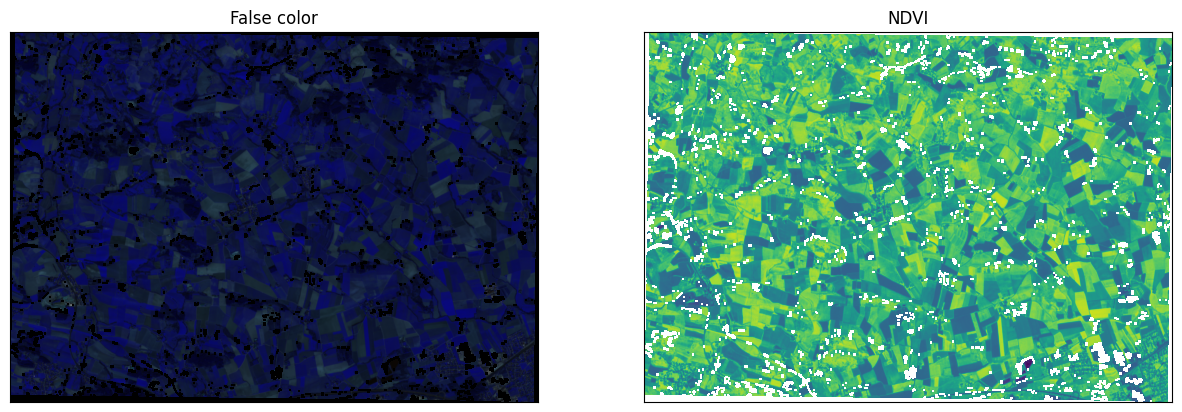

In [461]:
# Sanity Check

# False color comp
stack_np = s2timeseries.s2_ts.to_numpy()
single_date_false_color = stack_np[0,0:3,...]
# ndvi
ndvi = stack_np[0,5,...]

fig, ax = plt.subplots(1,2, figsize=(15, 15))
ax[0].set_title('False color')
ax[0].imshow(np.moveaxis(single_date_false_color, 0, -1))
ax[1].set_title('NDVI')
ax[1].imshow(ndvi)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);


## (2) Preparing vector data

In [509]:
# Load geopackage
# Shapely 2.0 + pyogrio fastes vector read/write speeds
fields_df = gpd.read_file(os.path.join(relpath,"eoml_response_croptypes.gpkg"), 
                          engine="pyogrio") 

# Add UID for rasterizing - his ID will be used throughout the ML process
fields_zone_id = "UID"
fields_df[fields_zone_id] = fields_df.index +1

# Get croptype classification and create integer map
croptype = fields_df['landuse'].unique()
croptype_map = {x:i for i,x in enumerate(list(croptype))}

# Sanity Check
fields_df.head(5)

,landuse,geometry,UID
0,SONSTIGE ACKERFLÄCHEN,"POLYGON ((13.96703 48.19236, 13.96709 48.19237...",1
1,WINTERGERSTE,"POLYGON ((14.06639 48.19583, 14.06640 48.19575...",2
2,GRÜNBRACHE,"POLYGON ((14.00121 48.23825, 14.00118 48.23815...",3
3,WINTERGERSTE,"POLYGON ((14.04966 48.18880, 14.05015 48.18898...",4
4,KÖRNERMAIS,"POLYGON ((14.00735 48.24179, 14.01297 48.24261...",5


After inspecting the fields data, it seemed appropriate to clean some of the fields. There are a lot of slivers, duplicates and loose fields, which would negatively impact the machine learning algorithm

In [510]:
print('Original fields amount :: ',fields_df.shape[0])

# check if the fields are projected - this is important for some area calcualtions
if fields_df.crs.is_projected == False:
    # Find an estimation of the common projected coordinate system Universal Transverse Mercator
    utmzone = fields_df.estimate_utm_crs()
    # Project fields dataframe
    fields_df = fields_df.to_crs(utmzone)

# Simple topology step - remove duplicate geometries
# More topology steps can be included, for this exe, this was sufficient.
fields_df = fields_df.drop_duplicates('geometry')

# calcualte shape statistics/characteristics
fields_df['area'] = fields_df['geometry'].area
fields_df['perimeter'] = fields_df['geometry'].length
fields_df['shape_index'] = fields_df.apply(lambda x: x['perimeter']**2/x['area'] ,axis=1)

# After inspection in a GIS the shape_index at 180 seemed a suitable threshold to remove most slivers
fields_df = fields_df.loc[fields_df['shape_index']<180]
# Remove polyogns which is smaller than an s2 pixel (100 m²)
fields_df = fields_df.loc[fields_df['area']>100]

print('Cleaned fields amount  :: ',fields_df.shape[0])

# Sanity Check
fields_df.head(5)

Original fields amount ::  3604
Cleaned fields amount  ::  2826


,landuse,geometry,UID,area,perimeter,shape_index
0,SONSTIGE ACKERFLÄCHEN,"POLYGON ((423232.461 5338196.593, 423236.953 5...",1,403.944466,84.665335,17.745556
1,WINTERGERSTE,"POLYGON ((430621.321 5338487.430, 430622.206 5...",2,15706.323072,492.217522,15.425513
3,WINTERGERSTE,"POLYGON ((429368.109 5337721.352, 429405.345 5...",4,16252.155993,601.405559,22.254810
4,KÖRNERMAIS,"POLYGON ((426300.034 5343650.716, 426717.930 5...",5,42438.807726,1123.634828,29.750016
5,SONSTIGE ACKERFLÄCHEN,"POLYGON ((425908.073 5343637.927, 425909.880 5...",6,102.550086,82.460476,66.306430


### (2a) - Mean per field with zonal statistics

This first apporach aims to calculate the mean of the spectral features per field using zonal statistics. This approach might give a more "pure" spectral result of the landuse/crop type, however it reduces the amount of data greatly. This appraoch would be better with a mutch larger set of fields

In [511]:
# Rasterize vector file for ability to calcualte zonal statistics    
fields_arr = rasterize_vector(fields_df, 
                             'UID', gdal_info['gt'], gdal_info['prj'],\
                              gdal_info['x_size'], gdal_info['y_size'], gdal_info['epsg'],
                              all_touched=True)

# Getting unique zones for zonal statistics to use later
unique_zones_fields = np.unique(fields_arr)
# remove 0 since its background
zero_idx = np.argwhere(unique_zones_fields==0)
unique_zones_fields = np.delete(unique_zones_fields, zero_idx)

print('Sucessfully rasterized fields :: ',len(unique_zones_fields))

Sucessfully rasterized fields ::  2795


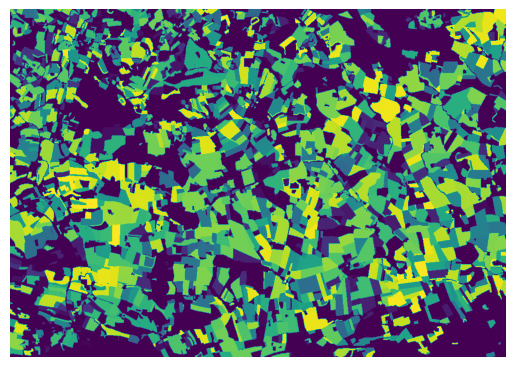

In [512]:
# Sanity Check
plt.axis('off')
plt.imshow(fields_arr)

#### Combining Raster and Vector data for fields

This codeblock extracts the raster data from the rasterized vector information and compiles it into a dataframe. In production this could be optimized with mulitprocessing, or a clever reworking of vectorized operations. For-loops are not the best, but intuative.

In [513]:
# Get neccisary iteratives
time_steps = s2timeseries.time.values
s2timeseries_np = s2timeseries.s2_ts.to_numpy()
bands_idx = {x:i for i,x in enumerate(list(s2timeseries.band.values))}

ml_df_init=0
# For each time step
for tsidx in tqdm(range(len(time_steps))):
    now_s2 = s2timeseries_np[tsidx]
    bnds_df_init=0
    
    # For each spectral fearture
    for bndkey in bands_idx:
        bnd_arr = now_s2[bands_idx[bndkey]]
        # Do zonal statistics
        return_df = vectorized_zonal_stats(bnd_arr, bndkey, fields_arr, unique_zones_fields, fields_zone_id, 
                                           zonal_stat='mean', nodata=np.nan)
        if bnds_df_init==0:
            bands_df = return_df
            bnds_df_init+=1
        else:
            bands_df = pd.merge(bands_df, return_df, on = fields_zone_id, how = 'outer')
    bands_df['date'] = time_steps[tsidx]
    if ml_df_init==0:
        ml_df_fields = bands_df
        ml_df_init+=1
    else:
        ml_df_fields= pd.concat([ml_df_fields,bands_df],ignore_index=True)

ml_df_fields = ml_df_fields.sort_values(by=['date'], ascending=[True])
print('Sucessfull fields with stats :: ', ml_df_fields['UID'].unique().shape[0])

100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

Sucessfull fields with stats ::  2790


### (2b) Random point samples within fields

This second approach adds points randomly to fields depending on their size. This apporach results in mutch more data, however migh also introduce some noise.

In [430]:
# Function that is mapped over the fields database
def sample_polygon(x):
    np.random.seed(7)
    # Get sample amount based on polygon area
    area = x.area
    if area < 14000:
        samples_amount=5
    elif area >= 14000 and area < 40000:
        samples_amount=11
    elif area >=40000 and area <80000:
        samples_amount=18
    elif area > 80000:
        samples_amount= 22
    
    # Create random samples within geometry extent 
    min_x, min_y, max_x, max_y = x.bounds
    ratio = x.area / x.envelope.area
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (samples_amount, 2) )
    multipoint = MultiPoint(samples)
    multipoint = multipoint.intersection(x)
    return multipoint

# Apply points function over fields dataframe and create points data frame
fields_df['points'] = fields_df['geometry'].apply(sample_polygon)
points_df = fields_df[['landuse','points']]
points_df = points_df.rename(columns={"points":"geometry"})
points_df = points_df.explode(index_parts=True)
points_df = points_df.reset_index()
points_df[fields_zone_id] = points_df.index+1
print('Points amount  :: ', points_df.shape[0])

Points amount  ::  11494


In [431]:
# Rasterize vector file for ability to calcualte zonal statistics/ get point data   
points_arr = rasterize_vector(points_df, 
                             'UID', gdal_info['gt'], gdal_info['prj'],\
                              gdal_info['x_size'], gdal_info['y_size'], gdal_info['epsg'],
                              all_touched=False)
# Getting unique zones for zonal statistics use later
unique_zones_points = np.unique(points_arr)
# remove 0 since its background
zero_idx = np.argwhere(unique_zones_points==0)
unique_zones_points = np.delete(unique_zones_points, zero_idx)

print('Sucessfully rasterized points :: ',len(unique_zones_points))

Sucessfully rasterized points ::  10858


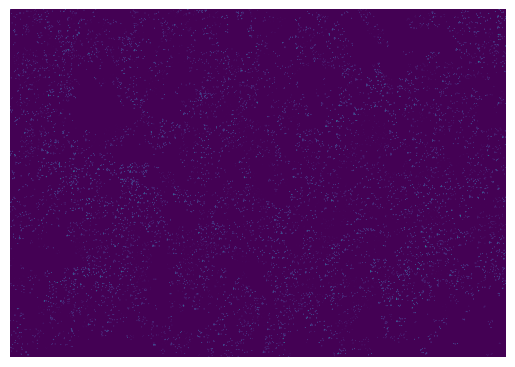

In [14]:
# Sanity Check
plt.axis('off')
plt.imshow(points_arr)

#### Combining Raster and Vector data for points

This codeblock extracts the raster data from the rasterized vector information and compiles it into a dataframe. In production this could be optimized with mulitprocessing, or a clever reworking of vectorized operations. For loops are not the best, but intuative.

In [432]:
# Get neccisary iteratives
time_steps = s2timeseries.time.values
s2timeseries_np = s2timeseries.s2_ts.to_numpy()
bands_idx = {x:i for i,x in enumerate(list(s2timeseries.band.values))}

ml_df_init=0
# For each time step
for tsidx in tqdm(range(len(time_steps))):
    now_s2 = s2timeseries_np[tsidx]
    bnds_df_init=0
    # For each spectral fearture
    for bndkey in bands_idx:
        bnd_arr = now_s2[bands_idx[bndkey]]
        # Do zonal statistics
        return_df = vectorized_zonal_stats(bnd_arr, bndkey, points_arr, unique_zones_points, fields_zone_id, 
                                           zonal_stat='mean')
        if bnds_df_init==0:
            bands_df = return_df
            bnds_df_init+=1
        else:
            bands_df = pd.merge(bands_df, return_df, on = fields_zone_id, how = 'outer')
    bands_df['date'] = time_steps[tsidx]
    if ml_df_init==0:
        ml_df_points = bands_df
        ml_df_init+=1
    else:
        ml_df_points= pd.concat([ml_df_points,bands_df],ignore_index=True)

ml_df_points = ml_df_points.sort_values(by=['date'], ascending=[True])
print('Sucessfull points with stats :: ', ml_df_points['UID'].unique().shape[0])

100%|██████████| 16/16 [00:02<00:00,  5.94it/s]

Sucessfull points with stats ::  10858


## (3) Process and prepare data

To continue, we need to choose a dataset, either `ml_df_fields` or `ml_df_points`. 
You can change this any time to see the effects.
`ml_df_points` will take longer to run than `ml_df_fields` 

This code block processes the raw spectral features into the 2W time grid and smoothes the time curve with the savitzky golay filter

In [514]:
# Defining the set fearture space
feature_space = ['B02_mean','B04_mean','B08_mean','B06_mean','B11_mean','ndvi_mean','ndmi_mean','ndvire_mean']

# DEFINE DATA SET HERE
# --------------------
in_df = ml_df_fields # either ml_df_fields or ml_df_points
raw_df = fields_df # either fields_df or points_df (should correlate with the above in_df)
# --------------------

# setup the time range
time_steps = in_df['date'].unique()
# Create regular 2 weekly date grid
date_range = pd.date_range(start=time_steps.min(), end=time_steps.max(), freq='2W')
date_range_df = pd.DataFrame(index=date_range)

# setup column names for xy dataframe
date_strings = [dt.strftime('%m_%d') for dt in date_range]
date_features = [f"{feat}_{dtstr}"  for feat in feature_space for dtstr in date_strings]
column_names=[fields_zone_id] + date_features

xy_dataframe=[]
for entry in tqdm(in_df[fields_zone_id].unique()):
    row=[]
    row.append(entry)
    for feature in feature_space:
        now_data_point = in_df[(in_df[fields_zone_id]==entry)][['date',feature]]
        now_data_point = now_data_point.set_index('date')
        # Resample and interpolate to the 2W regular gird
        resampled_data_point = pd.concat([now_data_point, date_range_df])
        resampled_data_point.sort_index(inplace=True)
        resampled_data_point = resampled_data_point.interpolate(method='linear')
        resampled_data_point = resampled_data_point[~resampled_data_point.index.duplicated()]
        resampled_data_point = resampled_data_point.reindex(date_range)

        # Smooth the series with the savitzky golay filter
        smoothed_point = signal.savgol_filter(resampled_data_point[feature], window_length=10, polyorder=3, mode="nearest")
        
        #row = row+list(smoothed_point)
        row = row+list(resampled_data_point[feature].to_list())
    xy_dataframe.append(row)

xy_df_comp = pd.DataFrame(xy_dataframe, columns=column_names)     

100%|██████████| 2790/2790 [00:42<00:00, 66.14it/s]


In [515]:
# Compile the final xy_df
xy_df = pd.merge(xy_df_comp, raw_df[[fields_zone_id,'landuse']], on = fields_zone_id, how = 'outer')
xy_df = xy_df.dropna()
xy_df['landuse'] = xy_df['landuse'].apply(lambda x: croptype_map[x])
xy_df

,UID,B02_mean_03_22,B02_mean_04_05,B02_mean_04_19,B02_mean_05_03,B02_mean_05_17,B02_mean_05_31,B02_mean_06_14,B02_mean_06_28,B02_mean_07_12,...,ndvire_mean_05_31,ndvire_mean_06_14,ndvire_mean_06_28,ndvire_mean_07_12,ndvire_mean_07_26,ndvire_mean_08_09,ndvire_mean_08_23,ndvire_mean_09_06,ndvire_mean_09_20,landuse
0,2.0,0.077708,0.083637,0.085889,0.097749,0.100913,0.082997,0.048786,0.034584,0.033514,...,0.077105,0.120086,0.157311,0.173471,0.189632,0.181483,0.163746,0.104952,0.102513,1
1,1449.0,0.066781,0.072547,0.067154,0.069980,0.066580,0.051968,0.034847,0.028863,0.028788,...,0.088617,0.104514,0.132623,0.152429,0.172235,0.182765,0.170276,0.124219,0.126095,1
2,1513.0,0.093749,0.110417,0.090676,0.074618,0.068703,0.050622,0.041705,0.044650,0.044347,...,0.103513,0.092071,0.085618,0.099608,0.113597,0.135746,0.141531,0.125011,0.139087,6
3,1577.0,0.043335,0.044956,0.031021,0.025264,0.022887,0.022707,0.030841,0.055055,0.073331,...,0.181897,0.139508,0.089213,0.074545,0.059877,0.035827,0.036252,0.025288,0.045772,5
4,1641.0,0.037355,0.038875,0.033592,0.031551,0.028042,0.026783,0.032348,0.041720,0.047778,...,0.141255,0.111595,0.083623,0.089380,0.095136,0.089707,0.080263,0.071498,0.105176,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,3495.0,0.125270,0.138701,0.115110,0.103593,0.100615,0.070846,0.037089,0.029156,0.028189,...,0.068946,0.100239,0.136719,0.156752,0.176785,0.180293,0.167572,0.128761,0.129827,18
2784,261.0,0.045900,0.050833,0.048100,0.044100,0.037367,0.032400,0.035683,0.039033,0.040867,...,0.117405,0.104752,0.097074,0.113637,0.130201,0.144559,0.143601,0.093806,0.167157,2
2785,277.0,0.073238,0.085548,0.089912,0.098104,0.097389,0.078993,0.050632,0.038332,0.036711,...,0.068530,0.104094,0.142690,0.162349,0.182009,0.183949,0.172361,0.118313,0.110683,3
2786,293.0,0.043169,0.042077,0.033308,0.029346,0.025393,0.027579,0.038931,0.058365,0.072586,...,0.195156,0.147472,0.103741,0.093214,0.082687,0.059371,0.054858,0.045193,0.074755,5


### Class imbalance
The class balance of the sample set is highly unbalanced. If I were to balance it, I would also remove some classes. I am not sure that this is in the scope. I would not error on the side of oversampling the lesser presented classes, as this might lead to some spatial autocorrelation effects (If i would over smaple the lesser represented fields all that the model learns from the one class is located in 1 or 2 fields, which is not ideal). Just to make you aware, I am aware of the high class imblalance, and its negative effects.

landuse
2     533
3     428
5     373
9     281
8     198
4     185
1     177
12    129
15    110
14     72
17     46
6      40
11     40
18     37
10     33
0      31
13     30
16     30
7      15
Name: count, dtype: int64


<Axes: xlabel='landuse'>

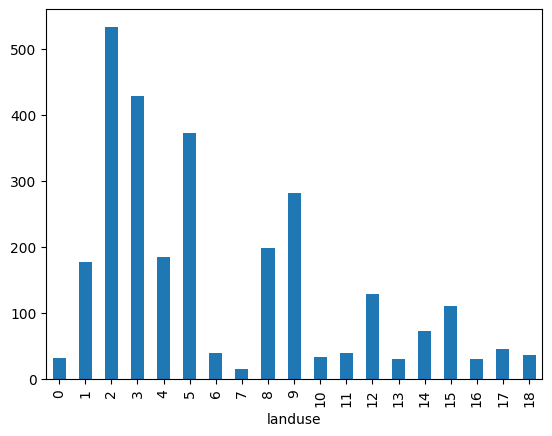

In [516]:
# Get an indication of class balance
entries_distribution= xy_df.landuse.value_counts()
print(entries_distribution)
plt.show()
entries_distribution.sort_index().plot.bar()

## (4) Data visualization

Geometry area:  0.0  m²


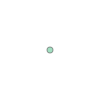

Landuse/Croptype
SOJABOHNEN


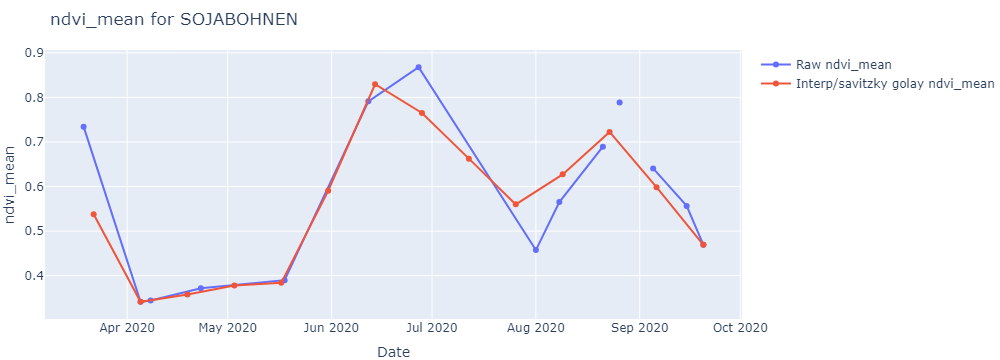

In [464]:
# Sanity checks to see the processing level of individual fields

# valid features 'B02_mean','B04_mean','B08_mean','B06_mean','B11_mean','ndvi_mean','ndmi_mean','ndvire_mean'
# Select and fearture to see
# --------------------------
selected_feature='ndvi_mean'
# --------------------------

# Selecting a random field/point id 
row_id = np.random.randint(in_df[fields_zone_id].min(), in_df[fields_zone_id].max())

# In a try, becuase not all ids where digitized
try:
    # If the points df was selected area and geomtery would be empty
    geom = raw_df.loc[raw_df[fields_zone_id]==row_id]['geometry'].iloc[0]
    print('Geometry area: ', round(geom.area,2), ' m²')
    display(geom)
    print('Landuse/Croptype')
    lu_key = xy_df.loc[xy_df[fields_zone_id]==row_id]['landuse'].iloc[0]
    lu_name=[x for x in croptype_map if croptype_map[x]==lu_key][0]
    print(lu_name)
    # Get original time series
    plot_origi = in_df.loc[in_df[fields_zone_id]==row_id][['date',selected_feature]]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=plot_origi['date'],
                             y=plot_origi[selected_feature],
                             name=f"Raw {selected_feature}" ))
    
    #fig = px.line(plot_origi, x=plot_origi['date'], y=plot_origi[selected_feature],markers=True)
    # Get interpolated and savitzky golay filter time series
    selected_cols=[x for x in list(xy_df.columns.values) if x.startswith(selected_feature)]
    plot_smooth = xy_df.loc[xy_df[fields_zone_id]==row_id][selected_cols].T
    plot_smooth = plot_smooth.rename(columns={plot_smooth.columns.values[0]:selected_feature})
    plot_smooth['date'] = plot_smooth.index
    plot_smooth['date'] = plot_smooth['date'].apply(lambda x: pd.to_datetime(f"2020_{x[-5:]}",format='%Y_%m_%d'))

    fig.add_trace(go.Scatter(x=plot_smooth['date'],
                             y=plot_smooth[selected_feature],
                             name=f"Interp/savitzky golay {selected_feature}" ))
    fig.update_layout(title=f"{selected_feature} for {lu_name}",
                      xaxis_title="Date",
                      yaxis_title=selected_feature,
                      margin=dict(l=0, r=0, b=0, t=50))

    fig.show()
except IndexError:
    print('Not digitized, please run again')

## (5) Train and tune the model

For training purposes I selected the LightGBM model (a gradient boosted tree model) because of its faster training speed and resource efficieny. For hyper parameter tuning I selected optuna. Optuna is easy to use and is quicker than sklearn's GridSearch and RandomizedSearch functions.

In [459]:
# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(xy_df[date_features], xy_df['landuse'], test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7457, 112), (3196, 112), (7457,), (3196,))

### (5a) unoptimized, no hyperparameters

First example is training and validating (with 5 fold cross validation) on a vanilla LightGBM model

In [485]:
# Setup cv folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Create empty structures for capturing cv results 
cv_models_acc=[]
models_dict = {}

# Loop through the folds
for fold_, (train_idx, val_idx) in tqdm(enumerate(folds.split(X_train, y_train))):

    # Split into train test further
    X_trcv, y_trcv = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valcv, y_valcv = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # fit model
    param={'verbose':-1}
    model = lgb.LGBMClassifier(**param)
    model.fit(X_trcv, y_trcv)

    # evaluate fit
    valid_preds = model.predict(X_valcv)
    acc = accuracy_score(y_valcv, valid_preds)
    cv_models_acc.append(acc)
    models_dict[int(acc*100)]=model

print('Mean classification accuracy   ::', round(sum(cv_models_acc)/len(cv_models_acc),2))
print('Highest lassification accuracy ::', round(max(cv_models_acc),2))

5it [00:12,  2.55s/it]

Mean classification accuracy   :: 0.57
Highest lassification accuracy :: 0.59


                                         precision    recall  f1-score   support

                  SONSTIGE ACKERFLÄCHEN       1.00      0.08      0.14        13
                           WINTERGERSTE       0.73      0.52      0.60       312
                             GRÜNBRACHE       0.36      0.61      0.46       254
                             KÖRNERMAIS       0.57      0.75      0.65       673
                         GRÜNLANDBRACHE       0.48      0.11      0.18       108
                      WINTERWEICHWEIZEN       0.61      0.74      0.67       673
                               KLEEGRAS       1.00      0.27      0.43        33
               SONSTIGE GRÜNLANDFLÄCHEN       0.00      0.00      0.00        11
                             SOJABOHNEN       0.69      0.53      0.60       347
         MÄHWIESE/-WEIDE ZWEI NUTZUNGEN       0.42      0.61      0.50       175
                           WECHSELWIESE       0.80      0.13      0.22        31
                           

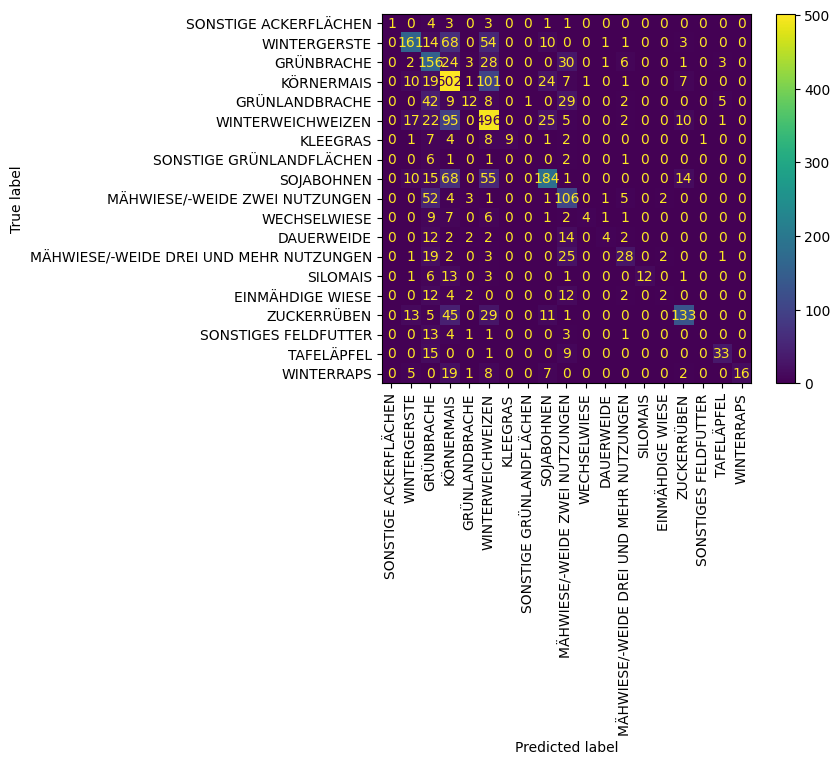

In [486]:
# Apply best model on unseen data
models_dict = dict(sorted(models_dict.items()))
best_model = list(models_dict.items())[-1][1]
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
clas_report = classification_report(y_test, y_pred, 
                                    labels=list(croptype_map.values()), 
                                    target_names=list(croptype_map.keys()))
print(clas_report)
cm = confusion_matrix(y_test, y_pred, labels=list(croptype_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(croptype_map.keys()))
disp.plot(xticks_rotation=90)

### (5b) unoptimized, random hyperparameters

Second example is training and validating (with 5 fold cross validation) on a LightGBM model with random hyper parameters

In [487]:
# Setup cv folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Create empty structures for capturing cv results 
cv_models_acc=[]
models_dict = {}

# Loop through the folds
for fold_, (train_idx, val_idx) in tqdm(enumerate(folds.split(X_train, y_train))):

    X_trcv, y_trcv = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valcv, y_valcv = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # Define random hyper paramters (found online)
    params = {
        "objective" : "multiclass",
        "metric" : "multi_logloss",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
        }

    # fit model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_trcv, y_trcv)
    
    # evaluate fit
    valid_preds = model.predict(X_valcv)
    acc = accuracy_score(y_valcv, valid_preds)
    cv_models_acc.append(acc)
    models_dict[int(acc*100)]=model

print('Mean classification accuracy   ::', round(sum(cv_models_acc)/len(cv_models_acc),2))
print('Highest lassification accuracy ::', round(max(cv_models_acc),2))

5it [00:10,  2.18s/it]

Mean classification accuracy   :: 0.42
Highest lassification accuracy :: 0.43


                                         precision    recall  f1-score   support

                  SONSTIGE ACKERFLÄCHEN       1.00      0.08      0.14        13
                           WINTERGERSTE       0.97      0.09      0.16       312
                             GRÜNBRACHE       0.47      0.31      0.38       254
                             KÖRNERMAIS       0.40      0.74      0.52       673
                         GRÜNLANDBRACHE       1.00      0.01      0.02       108
                      WINTERWEICHWEIZEN       0.37      0.76      0.50       673
                               KLEEGRAS       1.00      0.12      0.22        33
               SONSTIGE GRÜNLANDFLÄCHEN       0.00      0.00      0.00        11
                             SOJABOHNEN       0.82      0.15      0.25       347
         MÄHWIESE/-WEIDE ZWEI NUTZUNGEN       0.46      0.44      0.45       175
                           WECHSELWIESE       1.00      0.06      0.12        31
                           

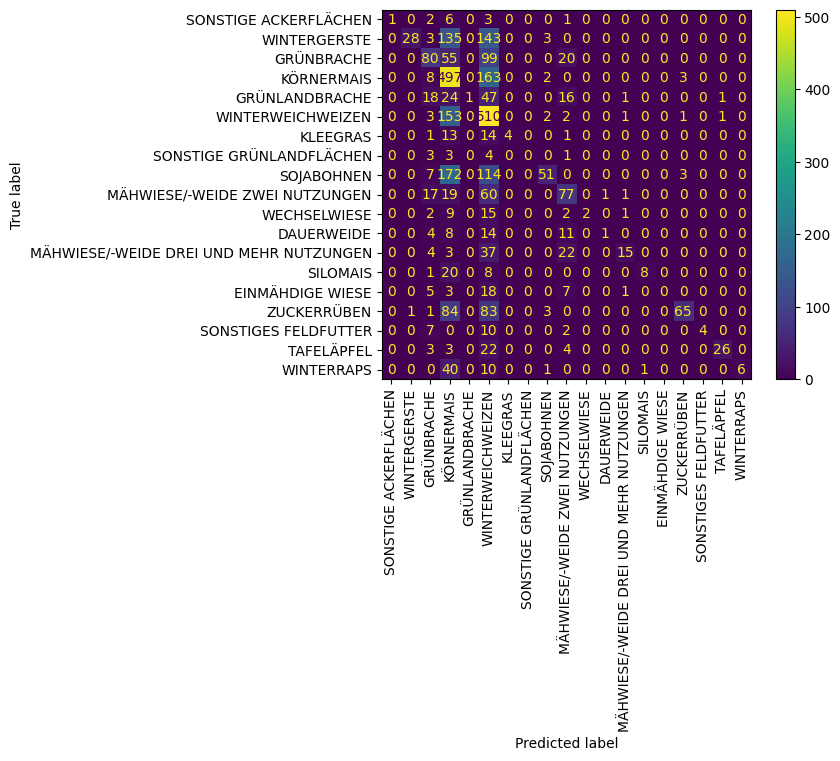

In [488]:
# Apply best model on unseen data
models_dict = dict(sorted(models_dict.items()))
best_model = list(models_dict.items())[-1][1]
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
clas_report = classification_report(y_test, y_pred, 
                                    labels=list(croptype_map.values()), 
                                    target_names=list(croptype_map.keys()))
print(clas_report)
cm = confusion_matrix(y_test, y_pred, labels=list(croptype_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(croptype_map.keys()))
disp.plot(xticks_rotation=90)

### (5c) optimized, optuna hyperparameters

Third example is training and validating (with 5 fold cross validation) on a LightGBM model with optimized hyper parameters through optuna 

In [489]:
# Define the trial funciotn wiht common lightGBM parameters and ranges thereof
dtrain = lgb.Dataset(X_train, label=y_train,params=params)
def objective(trial):
    # Hyper parameter definitions and ranges
    param = {
        "objective": "multiclass",
        "num_class": len(croptype_map),
        "metric": "multi_logloss",
        "verbose": -1,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 10),  
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    }

    # Fit and predict
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test).argmax(axis=1)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


In [490]:
# Execute hyper parametes search - THIS RUNS FOR QUITE A WHILE (ESPECIALLY WITH POINTS DF)

# turn of logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Start hyperparamter tuning 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: {}".format(len(study.trials)))

trial = study.best_trial
best_params = study.best_params
print("Best trial:",trial)

Number of finished trials: 50
Best trial: FrozenTrial(number=42, state=TrialState.COMPLETE, values=[0.5694618272841051], datetime_start=datetime.datetime(2023, 8, 28, 13, 26, 36, 460294), datetime_complete=datetime.datetime(2023, 8, 28, 13, 26, 56, 360786), params={'learning_rate': 0.009951477595675492, 'num_leaves': 219, 'scale_pos_weight': 9, 'feature_fraction': 0.8108822718050697, 'bagging_fraction': 0.9700661994357777, 'bagging_freq': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'scale_pos_weight': IntDistribution(high=10, log=False, low=1, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1)}, trial_id=42, value=None)


In [492]:
# Setup cv folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
best_params['verbose']=-1

# Create empty structures for capturing cv results 
cv_models_acc=[]
models_dict = {}

# Loop through the folds
for fold_, (train_idx, val_idx) in tqdm(enumerate(folds.split(X_train, y_train))):

    X_trcv, y_trcv = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valcv, y_valcv = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # fit model
    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_trcv, y_trcv)
    y_pred = model.predict(X_valcv)

    # evaluate fit
    score = accuracy_score(y_valcv, y_pred)
    cv_models_acc.append(acc)
    models_dict[int(acc*100)]=model
    
print('Mean classification accuracy   ::', round(sum(cv_models_acc)/len(cv_models_acc),2))
print('Highest lassification accuracy ::', round(max(cv_models_acc),2))

5it [00:56, 11.39s/it]

Mean classification accuracy   :: 0.41
Highest lassification accuracy :: 0.41


                                         precision    recall  f1-score   support

                  SONSTIGE ACKERFLÄCHEN       1.00      0.08      0.14        13
                           WINTERGERSTE       0.76      0.36      0.48       312
                             GRÜNBRACHE       0.37      0.57      0.45       254
                             KÖRNERMAIS       0.53      0.75      0.62       673
                         GRÜNLANDBRACHE       0.69      0.08      0.15       108
                      WINTERWEICHWEIZEN       0.54      0.75      0.63       673
                               KLEEGRAS       0.60      0.18      0.28        33
               SONSTIGE GRÜNLANDFLÄCHEN       0.00      0.00      0.00        11
                             SOJABOHNEN       0.70      0.38      0.49       347
         MÄHWIESE/-WEIDE ZWEI NUTZUNGEN       0.39      0.61      0.48       175
                           WECHSELWIESE       1.00      0.16      0.28        31
                           

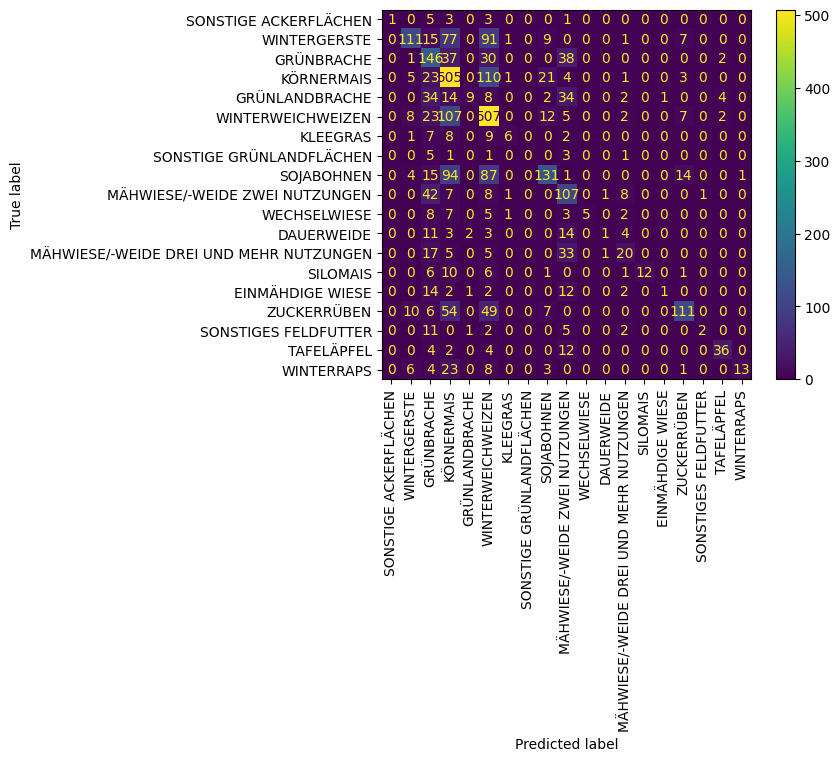

In [493]:
# Apply best model on unseen data
models_dict = dict(sorted(models_dict.items()))
best_model = list(models_dict.items())[-1][1]
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
clas_report = classification_report(y_test, y_pred, 
                                    labels=list(croptype_map.values()), 
                                    target_names=list(croptype_map.keys()))
print(clas_report)
cm = confusion_matrix(y_test, y_pred, labels=list(croptype_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(croptype_map.keys()))
disp.plot(xticks_rotation=90)

## Conclusions

From the results (both present in the fields dataframe and the points dataframe), the vanilla lightGBM model (no hyper parameter) tuning performed slightly better than the one which was tuned. This perhaps indicates that the data set is not big enough and not balanced enough to counter overfitting (due to hyper parameter tuning). It is not always the case that hyperparameter tuning would be the "silver bullet", especially when time and processing power is limited. However it is always wise to experiment with it (more usefull when you have more time and a deeper understanding of the model you are tuning)
 
Steps or ideas I would take to improve the ml process
 - The data was created and masked with the SCL layer. Better cloud algorithms are available and easily implementable (e.g. https://cloudsen12.github.io/)
 - I would more extensively clean the fields vector file and more rigourously check for topological inconsistencies. Some of the fields are still too small which could result in bad data.
 - I would still spend time to minimize any unneccisary for-loops
 - I would create more time series derivatives (e.g min-max, slope derivatives that would indicate rate of growth etc.)
 - I would create a more distributed point sampling scheme that would result in a more balanced data set (however not over sample smaller/lesser fields)
 - I would balance the dataset (as discussed earlier in the notebook)
 - I would add a further step to normalize the data a bit more to help prevent overfitting.
 - If training time was not a problem, I would consider a more sophisticated model, e.g. catboost or perhaps temporal CNN or an RNN
 - I know this is only for a code test, but the biggest improvement would be to have a bigger and more balanced field dataset.

With regards to the spatial autocorrelation question I will start of by quoting the abstract of *What is spatial autocorrelation? Reflections on the past 25 years of spatial statistics* (Daniel A. Griffith, 1992) which I still feel is relevant today, as I beleive there are slightly different interpretations of spatial auto correlation.

*To date a clear, simple, and concise definition of spatial autocorrelation has eluded the literature, although an increasing number of publications concerned with this concept have appeared in recent years. The scope of this problem is explored here, in a search for a meaning of spatial autocorrelation that is understandable to the average numerate geographer. The primary finding is that this concept can take on any one of the following nine different meanings: self-correlation attributable to the geographical ordering of data; a descriptor of the nature and degree of certain types of map pattern; an index of the information content latent in geo-referenced data, especially that information overlooked by classical statistical estimators when applied to spatial data series; a diagnostic tool for spatial model misspecification; a surrogate for unobserved geographic variables; a nuisance in applying conventional statistical methodology to spatial data series; an indicator of the appropriateness of, and possibly an artifact of, areal unit demarcation; a spatial process mechanism; and a spatial spillover effect. Each definition is spelled out, in turn, and either numerically or conceptually illustrated. One purpose of this exercise is to aid in the dissemination of introductory spatial statistical understanding throughout the geography community. The importance of attaining this goal lies in uses and potential abuses of spatial statistics that may accompany the proliferation of GIS throughout the technical community.*

So to eliminate any negative effects of spatial auto-correlation, in my opinion, is to have a really well balanced dataset in geographical variance and class variance. If I am training a crop model for Germany, but the majority of my data comes from Bavaria, the models hyperparameters would be overfitted to this regional bias. Similarly if the classification balance is biased towards a specific class (e.g. in this case GRÜNBRACHE and KÖRNERMAIS) the model will overfit to these classes. So the most improtant to consider is the ulimate goal of the model you want to train, and then to sample accordingly. In my oppinion the ground truth data and how it was sampled is much more important than the fine tuning of any ML model.

# PART 2 - GEE

### Setup and authorize google earth engine python api

In [517]:
import ee
ee.Authenticate()
ee.Initialize()

### imports

In [496]:
import sys
import geemap
import traceback
import shapely
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

### worker functions

This section contains some reusable worker functions, mainly for gee interaction

In [498]:
def STDEVsetDisplay(eeImage, bands, n, palette = {'palette':None}):
    """function for getting standard deviation display
  
    This functions draws stats form the give eeImage to calcuate
    a standard deviation strech in the geemap
    
    Args:
        eeImage:
          ee.Image object
        bands:
            string, what band/bands you want to strech
        n:
            integer scalling parameter
        palette:
            dictionaty of band statistics
    
    Returns:
        dictionary with band statistics for a standard deviation display
    """
    # Slighly more time consuming as getInfo() is called
    stdDev = eeImage.reduceRegion(reducer = ee.Reducer.stdDev(),scale=1000)
    mean = eeImage.reduceRegion(reducer = ee.Reducer.mean(),scale=1000)
    
    stdDev_dict = stdDev.getInfo()
    mean_dict = mean.getInfo()
    
    minarr = []
    maxarr = []
    for sb in bands:
        minarr.append(mean_dict[sb] - (stdDev_dict[sb]*n))
        maxarr.append(mean_dict[sb] + (stdDev_dict[sb]*n))
    
    if palette['palette'] == None:
        visParams = { 'bands':bands,
                      'min':minarr,
                      'max':maxarr}
    else:
        visParams = { 'bands':bands,
                      'min':minarr,
                      'max':maxarr,
                      'palette': palette['palette']}
    
    return visParams


def quality_masking(img):
    """Masking lidar height data on quality indicators
    
    Use the quality_flag and degrade_flag to mask data with low confidence
    https://doi.org/10.5194/isprs-archives-XLVIII-M-1-2023-131-2023
    
    Args:
        img:
            ee.Image object
    
    Returns:
        ee.Image object with updated mask
    """
    return img.updateMask(img.select('quality_flag').gt(0.9)).updateMask(img.select('degrade_flag').eq(0))


def cloud_masking(img):
    """L9 cloud masking
    
    Use the QA_PIXEL bitmap to mask clouds on landsat 9 surface reflectance image

    Args:
      img:
        ee.Image object
    Returns:
      ee.Image object with updated mask         
    """

    # select the bitmap
    qa = img.select('QA_PIXEL')
    # reclassify the bitmap and update the image mask
    cloud = qa.bitwiseAnd(1 << 1)\
              .Or(qa.bitwiseAnd(1 << 2))\
              .Or(qa.bitwiseAnd(1 << 3))\
              .Or(qa.bitwiseAnd(1 << 4))
    mask_ = img.mask().reduce(ee.Reducer.min())
    return img.updateMask(cloud.Not()).updateMask(mask_)

def add_ndvi(img):
  """Add normalized difference vegetation index

  Takes two bands and computes the normalized difference vegetation index and adds it as a band

  Args:
    img:
      ee.Image object

  Returns:
    ee.Image object with newly added band
  """
  
  nd_index = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
  return img.addBands(nd_index)

def add_ndwi_1(img):
  """Add normalized difference water index 1

  Takes two bands and computes the normalized difference water index 1 and adds it as a band

  Args:
    img:
      ee.Image object

  Returns:
    ee.Image object with newly added band
  """
  
  nd_index = img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI_1')
  return img.addBands(nd_index)

def add_ndwi_2(img):
  """Add normalized difference water index 2

  Takes two bands and computes the normalized difference water index 2 and adds it as a band

  Args:
    img:
      ee.Image object

  Returns:
    ee.Image object with newly added band
  """
  
  nd_index = img.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDWI_2')
  return img.addBands(nd_index)


def get_image_stat(img, geometry, stat, band, bins=30):
  """Simple function to get image statistic

  Uses the reduce functionality to get a statistic of the image

  Args:
    img:
      ee.Image object
    geometry:
      ee.Geometry.Polygon - this would be your aoi
    stat:
      string indicating what stat to calculate
      for this example only mean and standard deviation is supported
      'mean','stdev' and 'histogram'
    band:
      what band in the ee.Image should be reduced
      this must be a valid band name in your image
    bins:
      How many histogram bins to use if histgram is chosen
  Returns
    returns the statistic value
  """
  if stat == 'mean':
    reducer = ee.Reducer.mean()
  elif stat == 'stdev':
    reducer = ee.Reducer.stdDev()
  elif stat == 'histo':
    reducer = ee.Reducer.histogram(bins)

  img_reduced = qc_filter_gedi_coll_median.reduceRegion(**{
    'reducer': reducer,
    'geometry': geometry,
    'scale': 30,
    'maxPixels': 1e19})
  
  return img_reduced.getInfo()[band]


def calcualte_rsqr(test_vali, ground_truth, clasified):
    """get r²

    Custom function for calculating r squared

    Args:
        test_vali:
            ee.featurecollection.FeatureCollection containing predicted and 
            validation data
        ground_truth:
            string name of the validation data
        clasified:
            string name if the classified data

    Returns:
            float value of R²
    """  

    y = test_vali.aggregate_array(ground_truth)
    y_arr = ee.Array(y)
    y_hat = test_vali.aggregate_array(clasified)
    y_hat_arr = ee.Array(y_hat)
    y_bar = test_vali.aggregate_mean(ground_truth).getInfo()
    
    ss_tot = y_arr.subtract(y_bar).pow(2).reduce(ee.Reducer.sum(),[0]).getInfo()[0]
    ss_res  = y_arr.subtract(y_hat_arr).pow(2).reduce(ee.Reducer.sum(),[0]).getInfo()[0]
    r_sqr = 1- (ss_res/ss_tot)
    return r_sqr

## Workflow

### setup data collections

This section creates the neccisary data collections GEDI and Landsat data and plot them

In [499]:
# Define custom AOI in the Democratic Republic of Congo
drc_aoi_bounds = [23.4458391661680103,-4.9909765875998229,
                  24.7226342174226872,-3.7166655734098435]
                  #[xmin, ymin, xmax, ymax]
drc_aoi_poly = shapely.box(*drc_aoi_bounds)
ee_geom_AOI = ee.Geometry.Polygon(list(drc_aoi_poly.exterior.coords))
drc_aoi_centoid = drc_aoi_poly.centroid

# Define reference time frame
start_date = '2022-01-01'
end_date = '2022-12-31'

# Initiate Global Ecosystems Dynamics Investigation (GEDI)lidar reference data
# Apply neccisary filters
gedi_coll = ee.ImageCollection("LARSE/GEDI/GEDI02_A_002_MONTHLY") \
            .filterDate(ee.Date(start_date), ee.Date(end_date)) \
            .filterBounds(ee_geom_AOI) \
            .map(quality_masking)

# Get the median Relative height metrics at 95% for the specified time frame
# Clip to the specified geometry
qc_filter_gedi_coll_median = gedi_coll.median().select("rh95").clip(ee_geom_AOI)

# import Landsat Collection and create a cloud-free median composite for the reference year 2022
# Initiate Landsat-8 spectral data
landsat_data = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
                  .filterDate('2022-01-01', '2022-12-31') \
                  .filterBounds(ee_geom_AOI) \
                  .filter(ee.Filter.lt('CLOUD_COVER', 50))\
                  .filter(ee.Filter.eq('WRS_PATH', 176)) \
                  .filter(ee.Filter.eq('WRS_ROW', 63)) \
                  .map(add_ndvi) \
                  .map(add_ndwi_1) \
                  .map(add_ndwi_2) \
                  .map(cloud_masking)

bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDWI_1','NDWI_2']
landsat_median_image = landsat_data.median().clip(ee_geom_AOI).select(bands)

sanity_check = True
if sanity_check:
  # Check the processed data in geemap

  # Intialize gee map
  my_map = geemap.Map()
  # Set start location
  my_map.setCenter(drc_aoi_centoid.x, drc_aoi_centoid.y, 9) # San Francisco Bay

  # Add google hybrid basemap
  my_map.add_basemap('HYBRID')
  
  # Add AOI geometry
  my_map.addLayer(ee_geom_AOI, {},'AOI')

  # Add landsat median image with custom streching
  my_map.addLayer(landsat_median_image.select(['SR_B4','SR_B3','SR_B2']),
                      STDEVsetDisplay(landsat_median_image, ['SR_B4','SR_B3','SR_B2'],2),
                      'Landsat composite 2022')
  my_map.addLayer(landsat_median_image.select(['NDVI']),
                          {'bands': ['NDVI'],'min': 0,'max': 0.5},
                           'Landsat NDVI 2022')
  # Add GEDI h95 median image with custom streching
  my_map.add_ee_layer(qc_filter_gedi_coll_median,
                          STDEVsetDisplay(qc_filter_gedi_coll_median, ['rh95'],1), 
                          'GEDI median 95th height')

  # Add layer control
  my_map.addLayerControl()
  display(my_map)

Map(center=[-4.353821080504833, 24.084236691795347], controls=(WidgetControl(options=['position', 'transparent…

### understanding the data

To be able to properly sample the data for the regression it is important to get an indication of the distribution of the tree height data so that a balanced sample set can be extracted from the tree height range.

In [503]:
# Use reducer to get mean of GEDI dataset
gedi_mean = get_image_stat(qc_filter_gedi_coll_median, ee_geom_AOI, 'mean', 'rh95')
gedi_stdev = get_image_stat(qc_filter_gedi_coll_median, ee_geom_AOI, 'stdev', 'rh95')
gedi_histogram = get_image_stat(qc_filter_gedi_coll_median, ee_geom_AOI, 'histo', 'rh95')

# Define 3 classes based on +- standard deviation from the mean
sample_strata={'low':{'max':gedi_mean-gedi_stdev,
                      'count':[]},
               'middel':{'min':gedi_mean-gedi_stdev,
                         'max':gedi_mean+gedi_stdev,
                         'count':[]},
               'high':{'min':gedi_mean+gedi_stdev,
                       'count':[]}}

# Sanity check the thresholds
print('Tree height class splits ::')
print(round(sample_strata['low']['max'],2))
print(round(sample_strata['middel']['min'],2), ' - ',
      round(sample_strata['middel']['max']),2)
print(round(sample_strata['high']['min'],2))

# See population distribution of the height among the 3 classes
for i in range(len(gedi_histogram['bucketMeans'])):
  if gedi_histogram['bucketMeans'][i] <= sample_strata['low']['max']:
    sample_strata['low']['count'].append(gedi_histogram['histogram'][i])
  elif (gedi_histogram['bucketMeans'][i] > sample_strata['middel']['min'])\
        and (gedi_histogram['bucketMeans'][i] <= sample_strata['middel']['max']):
    sample_strata['middel']['count'].append(gedi_histogram['histogram'][i])
  elif (gedi_histogram['bucketMeans'][i] > sample_strata['high']['min']):
    sample_strata['high']['count'].append(gedi_histogram['histogram'][i])

# Sanity check of class distribution
print('\nRough number of pixels per class ::')
populations=[]
for sample_class in sample_strata:
  print(sample_class, ' : ', int(sum(sample_strata[sample_class]['count'])), ' ~ pixels')
  populations.append(sum(sample_strata[sample_class]['count']))

# Take 95% of the lowest class population for the sample amount accross the 3 classes
print('')
sample_amount = int(min(populations)*0.95)
print('\n~ sample amount: ', sample_amount)

Tree height class splits ::
3.26
3.26  -  28 2
27.67

Rough number of pixels per class ::
low  :  15090  ~ pixels
middel  :  31624  ~ pixels
high  :  9987  ~ pixels


~ sample amount:  9487


### create training and testing data

Sample the GEDI and Landsat data to the according ranges defined above by using masks

In [505]:
# Combining tree heights with spectral data
combined_image= ee.Image([qc_filter_gedi_coll_median,landsat_median_image])

# Produce stratified train and test data sets based on the threshold defined above
sampling_init=0
for sampling in sample_strata:
  if sampling=='low':
    # Mask the combine image according to low tree heights
    now_combined_image =combined_image\
                        .updateMask(qc_filter_gedi_coll_median.select('rh95').lt(sample_strata[sampling]['max']))
  elif sampling=='middel':
    # Mask the combine image according to middel tree heights
    now_combined_image =combined_image\
                        .updateMask(qc_filter_gedi_coll_median.select('rh95').gt(sample_strata[sampling]['min']))\
                        .updateMask(qc_filter_gedi_coll_median.select('rh95').lt(sample_strata[sampling]['max']))
  elif sampling=='high':
    # Mask the combine image according to high tree heights
    now_combined_image =combined_image\
                        .updateMask(qc_filter_gedi_coll_median.select('rh95').gt(sample_strata[sampling]['min']))
    
  now_sample = now_combined_image.sample(scale=30,
                                          seed=7).randomColumn(seed=7)
  # see if samples needs to be reduced
  sample_size = now_sample.size().getInfo()
  if sample_size>sample_amount:
    fraction = sample_amount/sample_size
    now_sample = now_sample.filter(ee.Filter.lte('random', fraction))
  now_sample = now_sample.randomColumn(seed=7, columnName='train_test')

  # Generate train test wuth a 70/30 split
  if sampling_init==0:
    train = now_sample.filter(ee.Filter.lte('train_test', 0.7))
    test = now_sample.filter(ee.Filter.gt('train_test', 0.7))
    sampling_init+=1
  else:
    now_sample.randomColumn(seed=7, columnName='train_test')
    now_train = now_sample.filter(ee.Filter.lte('train_test', 0.7))
    train = train.merge(now_train)
    now_test = now_sample.filter(ee.Filter.gt('train_test', 0.7))
    test = test.merge(now_test)

# Sanity check train test samples
print('Train amount ::', train.size().getInfo())
print('Test amount  ::', test.size().getInfo())

Train amount :: 19844
Test amount  :: 8467


### build regression model and train


In [506]:
# Build and train Randomforest regression model and display feature importance
explanatory_variables = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDWI_1','NDWI_2']
regression_model= ee.Classifier.smileRandomForest(100) \
                      .setOutputMode('REGRESSION') \
                      .train( features=train,
                              classProperty='rh95',
                              inputProperties=explanatory_variables)
pprint(regression_model.explain().getInfo())

{'importance': {'NDVI': 854343188.585775,
                'NDWI_1': 714551540.0343716,
                'NDWI_2': 828791017.5090504,
                'SR_B1': 809314120.9554918,
                'SR_B2': 703394797.8962005,
                'SR_B3': 1261424875.4876328,
                'SR_B4': 791008585.4384166,
                'SR_B5': 822767877.7195281,
                'SR_B6': 807632179.2277585,
                'SR_B7': 928126473.9372398},
 'numberOfTrees': 100,
 'outOfBagErrorEstimate': 7.675821428138601}


In [507]:
# Get R squared using the test set
test_prediction = test.classify(regression_model)
test_vali = test_prediction.select(['rh95', 'classification'])
validation_r_sqaured = calcualte_rsqr(test_vali, 'rh95', 'classification')
print('Validation R square of: ', validation_r_sqaured)

Validation R square of:  0.6970023088044148


### Display final result

In [508]:
# Predict full landsat image
predicted_tree_heights = landsat_median_image.classify(regression_model)

# Intialize gee map
my_map = geemap.Map()
# Set start location
my_map.setCenter(drc_aoi_centoid.x, drc_aoi_centoid.y, 9) # San Francisco Bay

# Add google hybrid basemap
my_map.add_basemap('HYBRID')

# Add landsat median image with custom streching
my_map.addLayer(landsat_median_image.select(['SR_B4','SR_B3','SR_B2']),
                    STDEVsetDisplay(landsat_median_image, ['SR_B4','SR_B3','SR_B2'],2),
                    'Landsat composite 2022')
# Add predicted tree heights
my_map.addLayer(predicted_tree_heights,
                        {'min': 0,'max': 80,'palette':['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000']},
                        'Predicted tree heights')
# Add ledged for tree heights
my_map.add_colorbar({'min': 0,'max': 80,'palette':['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000']},
                    label="Tree heights (m)", 
                    layer_name= "Tree heights ledged")


# Add layer control
my_map.addLayerControl()
display(my_map)

Map(center=[-4.353821080504833, 24.084236691795347], controls=(WidgetControl(options=['position', 'transparent…

## Conclusions

To improve the model (e.g. tree heigh classification model for 2022) I would use Sentinel 2 imagery, since it has a higher spatial and temporal resolution. Since the GEDI data is available monthly I would make monthly or 2 monthly S-2  and GEDI composites so that the spectral data more closely correlates with the GEDI tree height data, which will ulimately lead to a more accurate model.

I would also improve the regression training to include some sort of cross validation to have more confidence in the result. 
If the tree model is to be a global tree model, I would add a lot more AOI's globally to sample from.